In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#导入绘图库

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别.

Using TensorFlow backend.
/home/tmp/anaconda3/envs/tttf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tmp/anaconda3/envs/tttf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tmp/anaconda3/envs/tttf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tmp/anaconda3/envs/tttf/lib/p

In [18]:
train_df=pd.read_csv("train_set.csv",parse_dates = ["date"],index_col = [0])
val_df=pd.read_csv("validation_set.csv",parse_dates = ["date"],index_col = [0])
test_df=pd.read_csv("test_set.csv",parse_dates = ["date"],index_col = [0])

a_df = pd.concat((train_df, val_df), axis=0, join='inner')
all_df = pd.concat((a_df, test_df), axis=0, join='inner')


In [3]:
ot_tr = train_df['OT'].values
ot_val = val_df['OT'].values
ot_ts = test_df['OT'].values

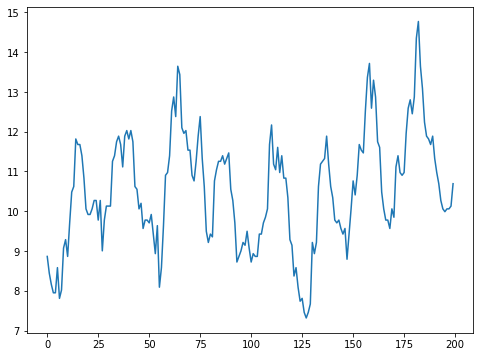

In [40]:
from sklearn.preprocessing import MinMaxScaler
# 创建MinMaxScaler对象
scaler = MinMaxScaler(feature_range = (-1, 1))

# 将数据进行归一化
all_df2 = scaler.fit_transform(all_df)
train_df = all_df2[:8640]
val_df = all_df2[8640:11616]
test_df = all_df2[11616:]
ot_ds = scaler.inverse_transform(test_df)
ot_ds = ot_ds[:,[-1]]
plt.figure(figsize=(8,6))
plt.plot([i for i in range(200)],ot_ds[:200])
plt.show()
plt.close()

In [7]:
def split_data(data,time_step=96):  # I = 96
    datax=[]
    datay=[]
    for i in range(len(data)-time_step):
        datax.append(data[i:i+time_step])
        datay.append(data[i+time_step])
    datax=np.array(datax).reshape(len(datax),time_step,-1)
    datay=np.array(datay)
    return datax,datay

In [8]:
train_x,train_y=split_data(train_df,time_step=96)
print(f"train_x.shape:{train_x.shape},train_y.shape:{train_y.shape}")

val_x,val_y=split_data(val_df,time_step=96)
print(f"val_x.shape:{val_x.shape},val_y.shape:{val_y.shape}")

test_x,test_y=split_data(test_df,time_step=96)
print(f"test_x.shape:{test_x.shape},test_y.shape:{test_y.shape}")


train_x.shape:(8544, 96, 7),train_y.shape:(8544, 7)
val_x.shape:(2880, 96, 7),val_y.shape:(2880, 7)
test_x.shape:(2880, 96, 7),test_y.shape:(2880, 7)


In [9]:
print("trainX[0]-- \n",train_x[0])
print("trainY[0]-- ",train_y[0])

trainX[0]-- 
 [[ 1.76454305e-01 -9.01143322e-02  1.98921194e-01 -5.26549462e-02
   1.13152999e-01  2.27530021e-01  3.82035264e-01]
 [ 1.70260481e-01 -8.11029118e-02  1.93476179e-01 -5.79870967e-02
   1.00557527e-01  2.41566705e-01  2.72465935e-01]
 [ 1.45485247e-01 -1.26160062e-01  1.82637039e-01 -6.85032799e-02
   2.51909681e-02  1.72288917e-01  2.72465935e-01]
 [ 1.42388346e-01 -9.91257686e-02  1.82637039e-01 -6.31711294e-02
   3.13854696e-02  1.99909469e-01  1.62936515e-01]
 [ 1.54775951e-01 -9.91257686e-02  1.93476179e-01 -5.26549462e-02
   4.39809906e-02  1.99909469e-01  3.93115952e-02]
 [ 1.67163579e-01 -7.20914914e-02  1.95308148e-01 -4.21387674e-02
   8.17675043e-02  2.41566705e-01  8.40536522e-03]
 [ 2.38392400e-01  3.60457136e-02  2.26044496e-01 -5.25807174e-03
   2.83088977e-01  4.62078357e-01  7.30129494e-02]
 [ 2.50780028e-01  8.11028797e-02  2.35102557e-01  3.16226239e-02
   2.95684449e-01  6.27801668e-01  8.70684641e-02]
 [ 1.64066678e-01  4.50571340e-02  2.42328651e-01 

In [10]:
print(train_y.shape)

(8544, 7)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 23,047
Trainable params: 23,047
Non-trainable params: 0
_________________________________________________________________

Train on 8544 samples, validate on 2880 samples
Epoch 1/22
8544/8544 [==============================] - 73s 9ms/step - loss: 0.1023 - val_loss: 0.0963
Epoch 2/22
8544/8544 [==============================] - 72s 8ms/step - loss: 0.0672 - val_loss: 0.0816
Epoch 3/22
8544/8544 [==============================] - 72s 8ms/step - loss: 0.0629 - val_loss: 0.0784
Epoch 4/22
8544/8544 [

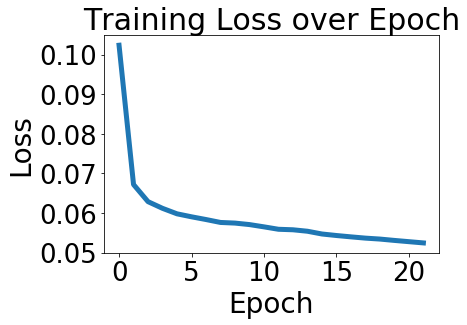

Final loss value: 0.05245799705218733


In [11]:
# LSTM Model 1 

x = train_x
y = train_y
in_dim = (96,7)
out_dim = 7

model = Sequential()

model.add(LSTM(units=64, input_shape=in_dim, activation="relu")) 
model.add(Dense(64, activation="relu"))
model.add(Dense(out_dim))

model.compile(loss='mae', optimizer='adam')  
model.summary()

hist = model.fit(x, y, epochs=22, validation_data = (val_x,val_y), verbose=1)

plt.plot([i for i in range(len(hist.history['loss']))], hist.history['loss'], linewidth=5)
plt.title('Training Loss over Epoch', fontdict={'size'   : 30})
plt.ylabel('Loss', fontdict={'size'   : 28})
plt.xlabel('Epoch', fontdict={'size'   : 28})
plt.xticks(size = 26)
plt.yticks(size = 26)
plt.show()
print('Final loss value:', hist.history['loss'][-1])


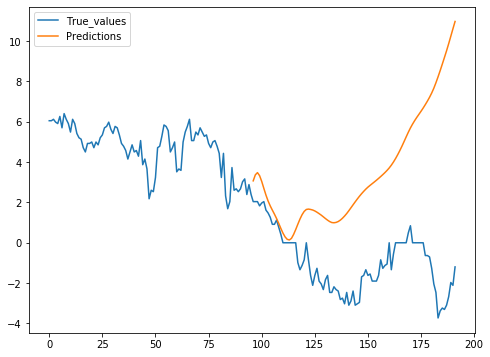

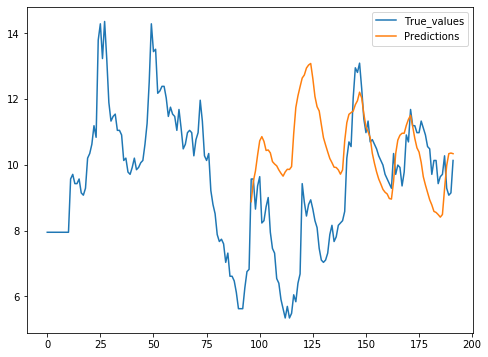

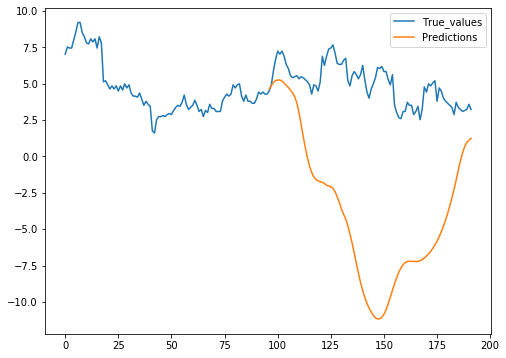

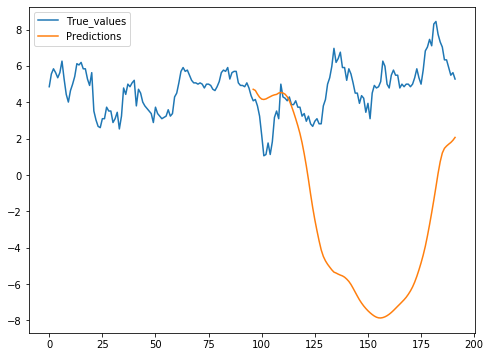

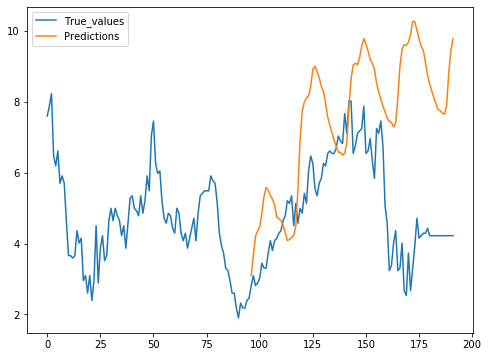

In [55]:
# Forecast 
import random

mae = []
mse = []
for i in range(5):
    ans = []
    p = random.randint(1, 2784)
    input_data = test_df[p : p + 96]
    for j in range(96):
        if j > 0:
            in_data = np.array([np.concatenate((input_data[j:],ans),axis=0)])
            output_data = model.predict(in_data)
            ans = np.concatenate((ans,output_data),axis=0)

        else:
            in_data = np.array([input_data])
            output_data = model.predict(in_data)
            ans = output_data

    
    real = scaler.inverse_transform(test_df[p+96: p+192])
    real2 = scaler.inverse_transform(test_df[p: p+192])
    pred = scaler.inverse_transform(ans)

    
# #     real = test_df[p+96: p+192]
# #     real2 = test_df[p: p+192]
# #     pred = ans
    
#     resulta= np.mean(np.abs(real,pred))
#     results = np.mean((real-pred)**2)
#     mae.append(resulta)
#     mse.append(results)
    
    ot_ds = real2[:,[-1]]
    ot_dd = pred[:,[-1]]
       
    plt.figure(figsize=(8,6))
    plt.plot(ot_ds,label='Real')
    plt.plot([i+96 for i in range(len(ot_dd))], ot_dd, label='Target Series')
    plt.legend(['True_values','Predictions'])
    plt.show()
    plt.close()

# print(mae)
# print(mse)



In [54]:
a = [5.22046, 4.862485, 4.4834356, 5.0587897, 4.682622]
print(np.mean(a))
print(np.std(a))
b = [34.31377519567269, 35.81123317637288, 0.9787946181978788, 50.98404100841499, 13.368284857173595]
print(np.mean(b))
print(np.std(b))

4.86155846
0.26180393041151695
27.09122577116641
17.715803890001993
